In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install torchbearer

     |████████████████████████████████| 143kB 4.7MB/s 


In [3]:
import torch
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchbearer
from torch.utils.data import DataLoader, Dataset
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/My Drive/MSc/data/data.csv')

In [5]:
df = df.drop(['Attributes'], axis=1)
df = df.drop([1], axis=0)
col = [att + ' ' + df[att][0] for att in df.columns]
df.columns = col
df = df.drop([0])

In [6]:
df.columns

Index(['Adj Close AAPL', 'Adj Close.1 GOOGL', 'Adj Close.2 MSFT',
       'Adj Close.3 ^IXIC', 'Adj Close.4 ^GSPC', 'Close AAPL', 'Close.1 GOOGL',
       'Close.2 MSFT', 'Close.3 ^IXIC', 'Close.4 ^GSPC', 'High AAPL',
       'High.1 GOOGL', 'High.2 MSFT', 'High.3 ^IXIC', 'High.4 ^GSPC',
       'Low AAPL', 'Low.1 GOOGL', 'Low.2 MSFT', 'Low.3 ^IXIC', 'Low.4 ^GSPC',
       'Open AAPL', 'Open.1 GOOGL', 'Open.2 MSFT', 'Open.3 ^IXIC',
       'Open.4 ^GSPC', 'Volume AAPL', 'Volume.1 GOOGL', 'Volume.2 MSFT',
       'Volume.3 ^IXIC', 'Volume.4 ^GSPC'],
      dtype='object')

In [7]:
close_aapl = df['Close AAPL'].copy().to_numpy()

In [8]:
close_aapl_scaler = preprocessing.MinMaxScaler()
close_aapl = close_aapl_scaler.fit_transform(close_aapl.reshape(-1, 1))

In [9]:
dates = pd.read_csv('/content/drive/My Drive/MSc/data/data.csv')['Attributes'].drop([0,1]).to_numpy()
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

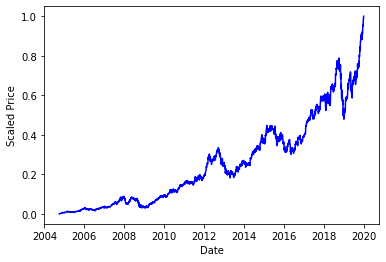

In [10]:
import matplotlib.pyplot as plt
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.plot(dates, close_aapl,color='blue')

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class lstm(nn.Module) :
    def __init__(self, input_size, hidden_size, hidden1, n_layers, seq_len) :
        super(lstm, self).__init__()
        self.insize = input_size
        self.hdsize = hidden_size
        self.ousize = 1
        self.seq_len = seq_len
        self.layer = n_layers
        self.lstm_cell = nn.LSTM(input_size=self.insize,
            hidden_size=self.hdsize,num_layers=self.layer, batch_first=True)
        self.fc = nn.Linear(self.hdsize, hidden1)
        self.fc1 = nn.Linear(hidden1, 1)

    def forward(self, x) :
        self.h_state = (torch.zeros(self.layer, len(x), self.hdsize).to(device),
                        torch.zeros(self.layer, len(x), self.hdsize).to(device))
        lstm_out, self.h_state = self.lstm_cell(x, self.h_state)
        out = lstm_out.squeeze()[:,-1,:]
        out = self.fc(out)
        out = F.sigmoid(out)
        out = self.fc1(out)
        return out

In [12]:
aapl = torch.from_numpy(close_aapl)

In [13]:
def create_dataset(data_scaled, seq_length, distance) :
    xs = []
    ys = []
    for i in range(data_scaled.shape[0]-distance-seq_length-1) :
        x = data_scaled.clone()[i:i+seq_length]
        y = data_scaled.clone()[i+seq_length+distance-1]
        xs.append(x)
        ys.append(y)
    return xs, ys

In [14]:
seq_length = 50
distance = 7
xs, ys = create_dataset(aapl, seq_length, distance)
xs = torch.stack(xs)
ys = torch.stack(ys)
xs.shape, ys.shape

(torch.Size([3781, 50, 1]), torch.Size([3781, 1]))

In [15]:
train_inp = xs.clone()[:3500,:]
train_out = ys.clone()[:3500]
test_inp = xs.clone()[3500:,:]
test_out = ys.clone()[3500:]

In [16]:
train_inp = train_inp.to(device).float()
train_out = train_out.to(device).float()
test_inp = test_inp.to(device).float()
test_out = test_out.to(device).float()

In [17]:
def train_model(opt, lr, epoch=100, print_output=False) :
    model = lstm(1, 50, 128, 1, seq_length).to(device)
    if (opt == 'Adam') :
        optimiser = optim.Adam(model.parameters(), lr=lr)
    if (opt == 'SGD') :
        optimiser = optim.SGD(model.parameters(), lr=lr)

    loss_function = nn.MSELoss(reduction='sum')

    train_hist = torch.zeros(epoch)
    test_hist = torch.zeros(epoch)

    for e in range(epoch) :
        
        train_pred = model(train_inp)

        train_loss = loss_function(train_pred.float(), train_out)

        with torch.no_grad() :
            test_pred = model(test_inp) 
            test_loss = loss_function(test_pred.float(), test_out)
        
        train_hist[e] = train_loss.item()
        test_hist[e] = test_loss.item()

        if e % 10 == 0 and print_output :
            print('Train loss:', train_hist[e], '\nTest loss:', test_hist[e])

        optimiser.zero_grad()

        train_loss.backward()

        optimiser.step()
    return train_hist, test_hist, train_pred.cpu().detach(), test_pred.cpu().detach()


In [38]:
train_hist = []
test_hist = []
pred_tr = []
pred_te = []

tr_h, te_h, pr_tr, pr_te = train_model('Adam', 1e-4, 200)
train_hist.append(tr_h)
test_hist.append(te_h)
pred_tr.append(pr_tr)
pred_te.append(pr_te)

tr_h, te_h, pr_tr, pr_te = train_model('Adam', 1e-3, 200)
train_hist.append(tr_h)
test_hist.append(te_h)
pred_tr.append(pr_tr)
pred_te.append(pr_te)

tr_h, te_h, pr_tr, pr_te = train_model('SGD', 1e-4, 200)
train_hist.append(tr_h)
test_hist.append(te_h)
pred_tr.append(pr_tr)
pred_te.append(pr_te)

tr_h, te_h, pr_tr, pr_te = train_model('SGD', 1e-5, 200)
train_hist.append(tr_h)
test_hist.append(te_h)
pred_tr.append(pr_tr)
pred_te.append(pr_te)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


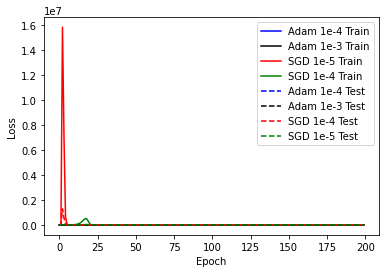

In [39]:
plt.plot(range(200), train_hist[0], color='blue')
plt.plot(range(200), train_hist[1], color='black')
plt.plot(range(200), train_hist[2], color='red')
plt.plot(range(200), train_hist[3], color='green')
plt.plot(range(200), test_hist[0], color='blue', linestyle='dashed')
plt.plot(range(200), test_hist[1], color='black', linestyle='dashed')
plt.plot(range(200), test_hist[2], color='red', linestyle='dashed')
plt.plot(range(200), test_hist[3], color='green', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Adam 1e-4 Train', 'Adam 1e-3 Train',
            'SGD 1e-5 Train', 'SGD 1e-4 Train',
            'Adam 1e-4 Test', 'Adam 1e-3 Test',
            'SGD 1e-4 Test', 'SGD 1e-5 Test'])

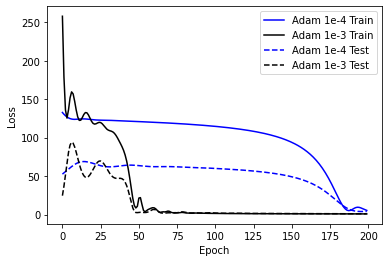

In [40]:
plt.plot(range(200), train_hist[0], color='blue')
plt.plot(range(200), train_hist[1], color='black')
plt.plot(range(200), test_hist[0], color='blue', linestyle='dashed')
plt.plot(range(200), test_hist[1], color='black', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Adam 1e-4 Train', 'Adam 1e-3 Train',
            'Adam 1e-4 Test', 'Adam 1e-3 Test'])

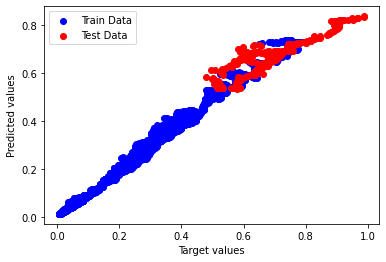

In [41]:
plt.scatter(train_out.cpu().detach(), pred_tr[1], color='blue')
plt.scatter(test_out.cpu().detach(), pred_te[1], color='red')
plt.ylabel('Predicted values')
plt.xlabel('Target values')
plt.legend(['Train Data', 'Test Data'])

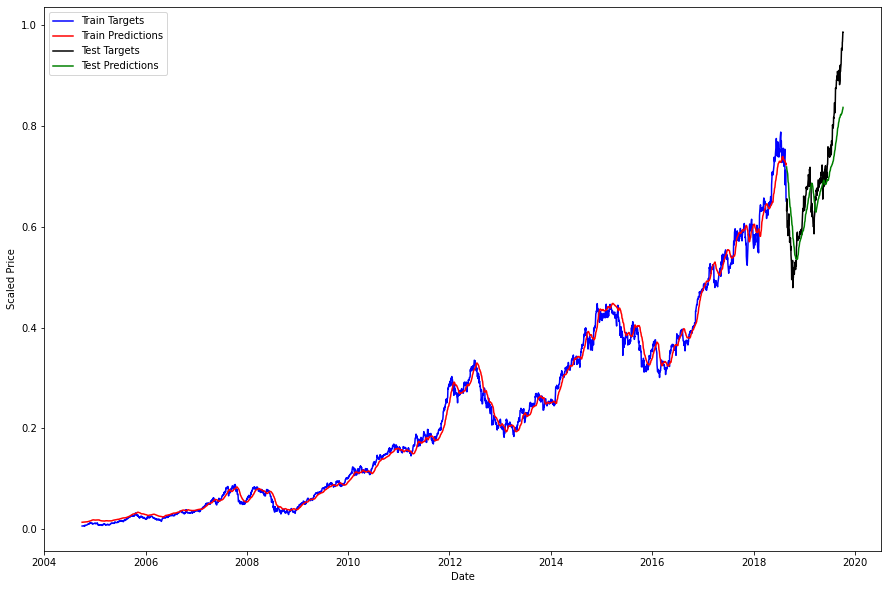

In [43]:
fig = plt.figure(figsize=(15,10))
plt.plot(dates[:len(train_out)], train_out.cpu().detach(), color='blue')
plt.plot(dates[:len(train_out)], pred_tr[1], color='red')
plt.plot(dates[len(train_out): len(train_out) + len(test_out)], test_out.cpu().detach(), color='black')
plt.plot(dates[len(train_out): len(train_out) + len(test_out)], pred_te[1], color='green')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend(['Train Targets', 'Train Predictions', 'Test Targets', 'Test Predictions'])